### FUTBOL MAÇLARININ VERİLERİNİ ÇEKEREK OYNANAN MAÇLARA SKOR TAHMİN MODELİ KURMAK ###

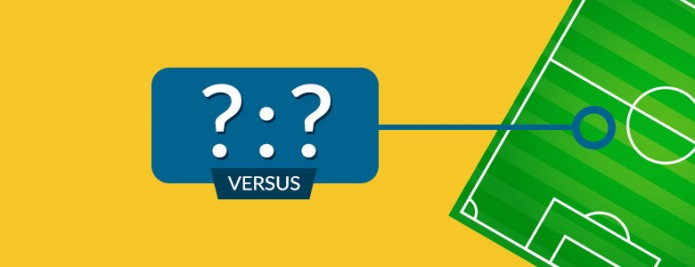

Tamamen kişisel merak üzerine çıkan fakat aslında pek orjinal olmayan bir fikir üzerine böyle bir proje yapmak istedim. Hali hazırda skor tahmin sitelerini görmüşsünüzdür. Neredeyse tamamı belirli bir ücret karşılığı hizmet veren bu sitelerden ziyade kendim tahmin üretecek bir model geliştirmek istedim.

Yaptığım bu çalışmanın birçok eksik yanı var farkındayım. Aslında bu eksiklikleri isteyerek bıraktım. İlk versiyon olarak düşündüğüm bu projeyi hem Türkçe kaynak olarak kullanılabilmesi için hem de bir sonraki aşama için ön hazırlık olmasını istedim. Bir sonraki versiyonda eksikliklerin bir bölümü tamamlanacak ve "deploy" edilmeye tamamen hazır gelecek.Son versiyonda ise Flask kullanılarak deployment işlemi yapılacak. Diğer versiyonları İngilizce olarak paylaşacağım ve buradaki gibi detaylı anlatım yapmak yerine sadece kısa notlar ekleyeceğim.

Bu versiyonda;
* Öznitelik mühendisliği yapılmamıştır.
* Maç dakikası değişkeni kullanılmamıştır.
* Kodlarda düzeltme işlemleri ayrıntılı olarak yapılmamıştır.
* Toplam skor tahmini için sadece light gbm regressor kullanılmıştır.
* Hiperparametre optimizasyonu detaylı olarak yapılmamıştır.
* Toplam skor tahmini ile ilgili karar mekanizması oluşturulmamıştır.

Şu an için aklıma gelen eksiklikler bunlar. Diğer versiyonlarda bu eksiklikler ve aklıma şu an için gelmeyen eksiklikler tamamlanacaktır.

Şimdi gelelim projeyi olabildiğince detaylı olarak anlatmaya

Kullanılan kütüphaneler aşağıda gördüğünüz gibidir. Eğer sizde yüklü olmayan kütüphane var ise *pip install kütüphane_ismi* şeklinde yükleyebilirsiniz. **Requests** ve **BeautifulSoup** kütüphanelerini veriyi çekerken , **lightgbm** kütüphanesini model oluşturmak için kullanacağız.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

pd.set_option('display.max_columns', None)

**requests.get** içerisindeki yıldızlı kısmı bilerek sansürledim. Yıldızlar yerine veriyi çekmek istediğimiz sitenin url'sini girmemiz gerekiyor.

**games** ve **games45** adında iki değişken oluşturma sebebim veriyi çektiğim sitede dakika 45'e kadar olan maçlar ve başlamamış maçlar *data-ish=0* olarak, ilk yarı bittikten sonra ise *data-ish=1* olarak tutuluyor. Yani çekeceğim veride başlamamış maçlar ile dakika 45e kadar olanlar ve 45ten sonra olanlar olacak şekilde iki farklı grupta çekeceğim.

In [2]:
r = requests.get('*************')
soup = BeautifulSoup(r.content, "lxml")
games = soup.find_all("tr", attrs={"data-ish": "1"})
games45 = soup.find_all("tr", attrs={"data-ish": "0"})

İşte bu kısım dakika 45'ten sonra yani *data-ish=1* olan veriyi çekmek için kullanacağımız alan. Boş bir liste oluşturuyoruz ve oluşturduğumuz listeye çektiğimiz verileri depoluyoruz.

In [3]:
list1 = []
for i in games:
    list1.append(i.find("td", attrs={"class": "text-center td_league"}).find("div", attrs={"href": ""}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_status"}).find("span", attrs={
        "class": "match_status_minutes"}).text)
    list1.append(i.find("td", attrs={"class": "text-right match_home"}).find("span", attrs={"class": ""}).text)
    list1.append(i.find("td", attrs={"class": "text-left match_away"}).find("span", attrs={"class": ""}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_goal"}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_corner"}).find("span", attrs={
        "class": "span_match_corner"}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_corner"}).find("span", attrs={
        "class": "span_half_corner"}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_attach"}).find("div", attrs={
        "class": "match_dangerous_attacks_div"}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_attach"}).find("div", attrs={
        "class": "match_dangerous_attacks_half_div"}).text)
    list1.append(
        i.find("td", attrs={"class": "text-center match_shoot"}).find("div", attrs={"class": "match_shoot_div"}).text)
    list1.append(i.find("td", attrs={"class": "text-center match_shoot"}).find("div", attrs={
        "class": "match_shoot_half_div"}).text)

Burada başlamamış maçlar ile dakika 45'ten önce yani *data-ish=0* olan veriyi çekmek için kullandığımız alan. Yukarıdaki işlemlerle aynı işlemler yapılmıştır.

In [4]:
list2 = []
for i in games45:
    list2.append(i.find("td", attrs={"class": "text-center td_league"}).find("div", attrs={"href": ""}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_status"}).find("span", attrs={
        "class": "match_status_minutes"}).text)
    list2.append(i.find("td", attrs={"class": "text-right match_home"}).find("span", attrs={"class": ""}).text)
    list2.append(i.find("td", attrs={"class": "text-left match_away"}).find("span", attrs={"class": ""}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_goal"}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_corner"}).find("span", attrs={
        "class": "span_match_corner"}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_corner"}).find("span", attrs={
        "class": "span_half_corner"}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_attach"}).find("div", attrs={
        "class": "match_dangerous_attacks_div"}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_attach"}).find("div", attrs={
        "class": "match_dangerous_attacks_half_div"}).text)
    list2.append(
        i.find("td", attrs={"class": "text-center match_shoot"}).find("div", attrs={"class": "match_shoot_div"}).text)
    list2.append(i.find("td", attrs={"class": "text-center match_shoot"}).find("div", attrs={
        "class": "match_shoot_half_div"}).text)

Kolon ismi oluşturuyoruz ve bunun içine çektiğimiz verinin sıralamasındaki kolon isimlerini yazıyoruz.

Daha sonra 2 farklı dataframe oluşturup list1 ve list2'yi dataframe'e çeviriyoruz. Hala tek bir sütun olduğu için "temp" adında kolon ismi veriyorz.

11 değişkenimiz olduğu için dataframeleri 11 parçaya ayırıyoruz. En başta oluşturduğumuz kolon isimlerini artık verebiliriz.

df2'de henüz başlamamış maçlar ile 45 dakikanın altında olan veriler tutuluyor. Henüz başlamamış maçlarda hiç veri oluşmaması doğalken yeni başlamış maçlarda dakika dışında bir veri oluşmaması doğal. Bu sebeple henüz başlamamış maçların dakikasını sıfır olarak atıyoruz ve dakika değişkenini integera çeviriyoruz. Artık buradan filtreleme işlemi yapabiliriz.

Sıfırdan büyük olan dakikaları seçip bir liste içine atıyoruz ve dataframe'e çeviriyoruz.

Artık verilerimiz 45.dakikadan önce olan maçlar ve 45.dakikadan sonra olan maçlar olmak üzere iki parça. Bu iki dataframe'i birleştiyoruz.

In [5]:
column_names = ["LEAGUE", "MINUTES", "TEAM_1_NAME", "TEAM_2_NAME", "SCORE", "TOTAL_CORNER", "HALFTIME_CORNER",
                "TOTAL_ATTACKS", "HALFTIME_ATTACKS", "TOTAL_SHOTS", "HALFTIME_SHOTS"]
df = pd.DataFrame(list1)
df2 = pd.DataFrame(list2)
df.columns = ["temp"]
df2.columns = ["temp"]
df = pd.DataFrame(df.groupby(df.index // 11)["temp"].apply(list).values.tolist())
df2 = pd.DataFrame(df2.groupby(df2.index // 11)["temp"].apply(list).values.tolist())
df.columns = column_names
df2.columns = column_names

df2['MINUTES'] = df2['MINUTES'].replace("", value=0).astype("int")

list3 = []
for index, row in df2.iterrows():
    if row['MINUTES'] > 0:
        list3.append(row)
df3 = pd.DataFrame(list3, columns=column_names)

df_final = pd.concat([df, df3], ignore_index=True)

Bir fonksiyon oluşturuyoruz ve fonksiyon bu versiyon için veriyi hazır hale getiriyor.

Fonksiyonun ilk bölümünde henüz veri oluşmamış maçlardaki verileri dolduruyoruz. Daha sonra istediğimiz değişkenleri çeşitli işlemler sonucunda oluşturarak fonksiyonu tamamlıyoruz.

In [6]:
def data_col_pre(dataframe):
    dataframe = dataframe.replace("", "0-0")
    dataframe = dataframe.replace(" ", "0-0")
    dataframe.replace(np.nan, 0, inplace=True)

    dataframe["LEAGUE"] = dataframe["LEAGUE"].str.replace('\n', '')
    dataframe['HALFTIME_CORNER'] = dataframe['HALFTIME_CORNER'].str.replace('(', '').str.replace(')', '')
    dataframe[['HALFTIME_CORNER_TEAM_1', 'HALFTIME_CORNER_TEAM_2']] = dataframe["HALFTIME_CORNER"].str.split("-",
                                                                                                             expand=True)
    dataframe[['SCORE_TEAM_1', 'SCORE_TEAM_2']] = dataframe["SCORE"].str.split("-", expand=True)
    dataframe[['TOTAL_CORNER_TEAM_1', 'TOTAL_CORNER_TEAM_2']] = dataframe["TOTAL_CORNER"].str.split("-", expand=True)
    dataframe[['TOTAL_ATTACKS_TEAM_1', 'TOTAL_ATTACKS_TEAM_2']] = dataframe["TOTAL_ATTACKS"].str.split("-", expand=True)
    dataframe[['HALFTIME_ATTACKS_TEAM_1', 'HALFTIME_ATTACKS_TEAM_2']] = dataframe["HALFTIME_ATTACKS"].str.split("-",
                                                                                                                expand=True)
    dataframe[['TOTAL_SHOTS_TEAM_1', 'TOTAL_SHOTS_TEAM_2']] = dataframe["TOTAL_SHOTS"].str.split("-", expand=True)
    dataframe[['HALFTIME_SHOTS_TEAM_1', 'HALFTIME_SHOTS_TEAM_2']] = dataframe["HALFTIME_SHOTS"].str.split("-",
                                                                                                          expand=True)
    dataframe.replace(np.nan, 0, inplace=True)
    dataframe = dataframe.replace(" ", value=0)
    dataframe = dataframe.replace("Half", value=45)
    dataframe = dataframe.replace("", value=0)

    drop_list = ["SCORE", "TOTAL_CORNER", "HALFTIME_CORNER", "TOTAL_ATTACKS", "HALFTIME_ATTACKS", "TOTAL_SHOTS",
                 "HALFTIME_SHOTS"]
    dataframe.drop(drop_list, axis=1, inplace=True)

    non_int_list = ["LEAGUE", "TEAM_1_NAME", "TEAM_2_NAME"]
    for i in [col for col in dataframe.columns if col not in non_int_list]:
        dataframe[i] = dataframe[i].astype("int")

    dataframe = dataframe[
        ["LEAGUE", "TEAM_1_NAME", "SCORE_TEAM_1", "SCORE_TEAM_2", "TEAM_2_NAME", "TOTAL_CORNER_TEAM_1",
         "TOTAL_CORNER_TEAM_2",
         "TOTAL_ATTACKS_TEAM_1", "TOTAL_ATTACKS_TEAM_2", "TOTAL_SHOTS_TEAM_1", "TOTAL_SHOTS_TEAM_2",
         "HALFTIME_CORNER_TEAM_1",
         "HALFTIME_CORNER_TEAM_2", "HALFTIME_ATTACKS_TEAM_1", "HALFTIME_ATTACKS_TEAM_2",
         "HALFTIME_SHOTS_TEAM_1", "HALFTIME_SHOTS_TEAM_2"]]
    dataframe["TOTAL_SCORE"] = dataframe["SCORE_TEAM_1"] + dataframe["SCORE_TEAM_2"]
    return dataframe

df_final diye oluşturduğumuz iki dataframe'in birleşimini data_col_pre fonksiyonundan geçirerek yine aynı değişkene atıyoruz. Artık şu an devam eden maçların verisi hazır durumda

In [7]:
df_final = data_col_pre(df_final)

Bir alt kodda oluşturduğumuz scoredata.csv'yi old_data değişkenine atıyoruz. Neden bir alt kodda? Canlı maç verisini scoredata.csv'ye atmadan önce kullanmak istiyoruz.

In [8]:
old_data = pd.read_csv("scoredata.csv", error_bad_lines=False)

**İlk kayıttan sonrası için:** Oluşturduğumuz df_final dataframe'ini csv'ye çeviriyoruz ve scoredata.csv'e ekleme *(mode="a")* yapıyoruz. Ekleme yaptığımız için sütun isimlerini yazdırmıyoruz. 

**İlk kayıt için:** İlk kayıt işlemi sırasında böyle bir csv olmadığı için mode kısmını **w** olarak seçiyoruz. Kolon isimleri için ise header argümümanını True olarak seçiyoruz.

In [9]:
with open("scoredata.csv", mode="a", newline='' ,encoding='utf-8') as file:

    df_final_csv = df_final.to_csv(index=False, sep=",", header=False)
    file.write(df_final_csv)

Kullanmak istemediğimiz değişkenleri bir değişkene atıyoruz kolaylık olsun diye çünkü ileride de bu *for_x_drop_list* değişkenini kullanacağız.

X değişkenini istemediğiz değişkenleri kaldırarak tanımlıyoruz.
y değişkenine ise bağımlı değişken olan toplam skoru atıyoruz.

In [10]:
for_x_drop_list  = ["LEAGUE","TOTAL_SCORE","TEAM_1_NAME","TEAM_2_NAME","SCORE_TEAM_1","SCORE_TEAM_2"]

X = old_data.drop(for_x_drop_list, axis=1)
y = old_data["TOTAL_SCORE"]

Modelin ilk testini yapmak için X ve y için train ve test olmak üzere toplam 4 değişkene atıyoruz.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

Light gbm regressor modelimi kuruyoruz ve X_train'den y_train'i öğrenmesi için fit işlemini yapıyoruz.

Train ve test hatalarını kontrol etmek için modelin bağımlı değişken tahmin değerlerini atıyoruz. 

In [12]:
lgbm_model = LGBMRegressor(random_state=123).fit(X_train, y_train)

y_pred_train = lgbm_model.predict(X_train)

y_pred_test = lgbm_model.predict(X_test)

Train ve test hatalarına bakmak için rmse değerlerini oluşturuyoruz. (tercihe göre mse ya da mae de kullanılabilir).

Bir de cross validation işlemi sonucundaki rmse skoruna bakalım karşılaştırma yapmak için.

Eğitim seti için rmse değeri 0.496 iken test seti için 0.881 çıkmış. Daha iyi bir karşılaştırma için cross validation işlemi sonucundaki rmse değerine bakıyoruz. O ise 0.997 olarak gelmiş.

In [13]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

cv_score = np.sqrt(-cross_val_score(estimator=lgbm_model, X=X, y=y, cv=10, scoring="neg_mean_squared_error"))

print(f"Train Set RMSE: {rmse_train}, Test Set RMSE: {rmse_test} ")
print(f"CV Score Mean: {cv_score.mean()}, Standard Deviation: {cv_score.std()}")

Train Set RMSE: 0.49608539624414516, Test Set RMSE: 0.881678677343406 
CV Score Mean: 0.9979414896146845, Standard Deviation: 0.1741097843563869


Train ve test setlerini kullanarak hatalara baktık, tüm verinin cross validation sonrası hatasına baktık. Şimdi ise hiperparametre optimizasyonu yaparak modeli daha iyi hale getirmeye çalışacağız ve hatayı düşürmeyi hedefleyeceğiz.

Learning_rate, sub_feature, num_leaves ve max_depth için belirlediğimiz aralıklardan her biri için 5 değer oluşturuyoruz. Daha sonra GridSearchCV'de kullanmak için bu değişkenleri ve birkaç değişkeni daha lgbm_grid değişkeninin içerisine koyuyoruz.

In [14]:
iterations = 5
lr = []
sf = []
nl = []
md = []

for i in range(iterations):
    lr.append(np.random.uniform(0, 1))
    sf.append(np.random.uniform(0, 1))
    nl.append(np.random.randint(20, 300))
    md.append(np.random.randint(5, 200))

lgbm_grid = {"learning_rate":lr,"boosting_type":["gbdt","dart","goss"],"objective":["regression"],
             "metric":["rmse"],"sub_feature":sf,"num_leaves":nl,"max_depth": md }

Oluşturduğumuz lgbm_grid'i GridSearchCV'ye veriyoruz ve lgbmregressor'ı kullanarak model oluşturmasını istiyoruz.

4 tane 5 değişkenli bir liste oluşturmuştuk bir de boosting_type'da 3 değişken var yani her bir cv katı için 5 * 5 * 5 * 5 * 3= 1875 işlem yapacak. 5 iterasyon yapıyor olduğumuz için toplamda 9375 işlem yani model kurmuş olacak.

In [15]:
lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(param_grid=lgbm_grid,estimator=lgbm,cv=5, n_jobs=-1, verbose=-1).fit(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9375 out of 9375 | elapsed:  3.3min finished


[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7294988849604024. Current value: feature_fraction=0.7294988849604024


İşlem yaklaşık 3.5 dakika sürdü. Verdiğimiz değerler içerisinden en iyi sonuca göre parametrelere bakıyoruz. 

*Not:Farklı sayıda farklı aralıkta değerler verilerek daha başarılı ya da daha başarısız sonuçlara ulaşılabilir.*

In [16]:
lgbm_cv_model.best_params_

{'boosting_type': 'dart',
 'learning_rate': 0.639665830433791,
 'max_depth': 115,
 'metric': 'rmse',
 'num_leaves': 90,
 'objective': 'regression',
 'sub_feature': 0.7294988849604024}

GridSearchCV sonucu oluşan en iyi parametrelere göre final modelimizi kurup cross validation sonrası rmse ortalamasına bakalım son kez.

In [17]:
lgbm_final_model = lgbm.set_params(**lgbm_cv_model.best_params_).fit(X,y)
cv_score = np.sqrt(-cross_val_score(estimator=lgbm_final_model, X=X, y=y, cv=10, scoring="neg_mean_squared_error", n_jobs=-1,verbose=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Çok az da olsa düşmüş görünüyor. (önceki cv_score.mean()--> 0.997). Hiperparametre optimizasyonu daha fazla seçenek veya daha farklı sayılarla yapılırsa hata belirgin bir biçimde düşebilir.

In [18]:
cv_score.mean()

0.9853676251023739

Bir de değişkenlerin önem sıralarına görsel olarak bakalım.

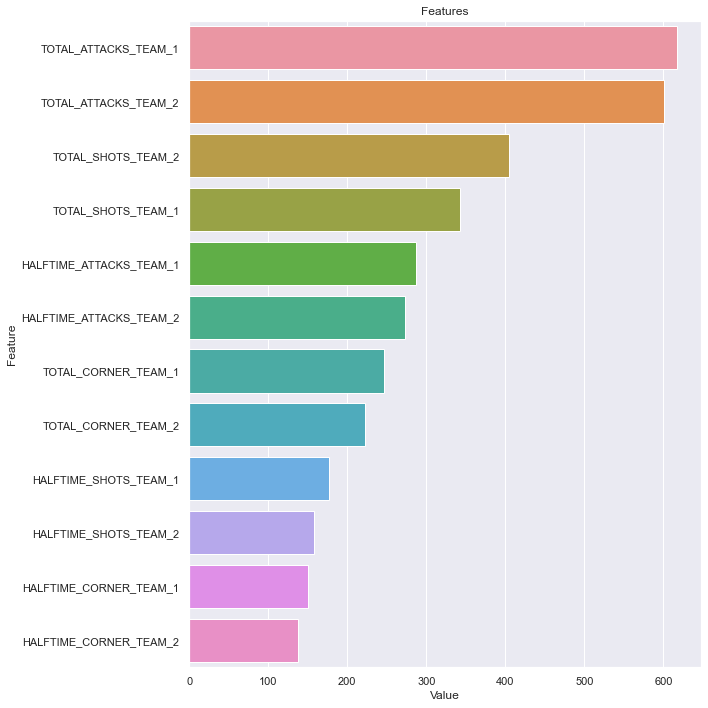

In [19]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    
plot_importance(lgbm_final_model, X)

Bu kısıma kadar hep eski verilerle model kurup yine eski verilerle hataları kontrol edip optimizasyon yapmaya çalışmıştık. Buraya kadar olan işlemler aslında veriyi tanıyıp modelin başarısını görmek içindi. Şimdi eski veriler ve oluşturduğumuz en iyi parametreleri kullanarak modeli oluşturup canlı olan maçlar üzerinde test edeceğiz. Bunun için veriyi train ve test olmak üzere manul olarak 4 parçaay ayırıyoruz.

In [20]:
X_train = old_data.drop(for_x_drop_list, axis=1)
X_test = df_final.drop(for_x_drop_list, axis=1)

y_train = old_data["TOTAL_SCORE"]
y_test = df_final["TOTAL_SCORE"]

Modeli kurup canlı olarak devam eden maçlar için bir tahmin oluşturmasını isteyelim.

In [21]:
lgbm_live_model = LGBMRegressor(**lgbm_cv_model.best_params_).fit(X_train, y_train)
y_pred = lgbm_live_model.predict(X_test)

Oluşturulan y_pred değişkenini dataframe'e çevirip df_final'e *EXPECTED_TOTAL_SCORE* değişkeni olarak atıyoruz. Olası bir sıfırdan küçük değer tahmin ederse diye bir düzeltme işlemi yapıyoruz.

In [22]:
expected = pd.DataFrame(y_pred, columns=["EXP_SCORE"])
expected["EXP_SCORE"] = expected["EXP_SCORE"].apply(lambda x: 0 if x<0 else x)
df_final["EXPECTED_TOTAL_SCORE"] = expected["EXP_SCORE"]

Evet şimdi oynanan maçlara ve tahminlere bakabiliriz.

In [23]:
df_final

,LEAGUE,TEAM_1_NAME,SCORE_TEAM_1,SCORE_TEAM_2,TEAM_2_NAME,TOTAL_CORNER_TEAM_1,TOTAL_CORNER_TEAM_2,TOTAL_ATTACKS_TEAM_1,TOTAL_ATTACKS_TEAM_2,TOTAL_SHOTS_TEAM_1,TOTAL_SHOTS_TEAM_2,HALFTIME_CORNER_TEAM_1,HALFTIME_CORNER_TEAM_2,HALFTIME_ATTACKS_TEAM_1,HALFTIME_ATTACKS_TEAM_2,HALFTIME_SHOTS_TEAM_1,HALFTIME_SHOTS_TEAM_2,TOTAL_SCORE,EXPECTED_TOTAL_SCORE
0,USA USL League Two,Toledo Villa FC,0,4,Flint City Bucks,3,5,26,34,2,7,3,5,26,34,2,7,4,2.133943
1,Womens International,Nicaragua Women,1,0,Dominican Rep Women,4,5,16,14,6,1,2,5,10,12,3,1,1,0.964476
2,USA WPSL Women,Chicago Dutch Lions Women,0,1,Chicago Red Stars Reserves Women,4,7,15,34,3,3,3,6,12,19,3,1,1,1.183594
3,USA WPSL Women,FC Pride Women,8,0,St. Louis Lions Women,8,0,53,4,29,0,8,0,33,3,15,0,8,4.984640
4,USA NPSL,FC Columbus,2,0,FC Indiana,6,2,42,10,14,2,4,1,33,5,13,2,2,3.079845
5,USA NPSL,West Chester United,4,1,Torch FC,8,3,48,29,15,10,6,2,34,20,10,6,5,5.440621
6,USA USL Championship,Charlotte Independence,2,1,New York Red Bulls II,4,4,49,38,9,8,3,4,35,30,7,7,3,3.433348
7,USA USL League Two,Grand Rapids FC,1,2,Oakland County FC,9,0,47,20,13,5,5,0,27,17,7,4,3,3.630159
8,Canada Premier League,Atletico Ottawa,0,0,Pacific FC,2,6,15,43,2,11,2,2,11,27,2,5,0,2.369942
9,Uruguay Segunda,Cerro,1,0,Villa Teresa,2,4,39,47,2,6,2,4,39,47,2,6,1,0.905957


Elimden geldiği kadar detaylı bir şekilde açıklamaya çalıştım. Umarım faydalı olmuştur.


https://www.linkedin.com/in/burakdogrul/

https://burakdogrul.medium.com/

http://www.burakdogrul.com/
